## The very very basics of ML. With R.

Experiment freely. This is a hands-on (brains off!) experience!

In [1]:
# you will not run this cell twice or you die

options(warn=-1, error = expression(NULL))
setwd('../../')

source('src/lib.R')

df = get_partitioned_df()

info = getModelInfo()

data_name = 'spirals'

Loading required package: tidyverse
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.2     v dplyr   0.7.4
v tidyr   0.8.0     v stringr 1.3.0
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: caret
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Loading required package: keras
Loading required package: mlbench
Loading required package: ggthemes
Loading required package: assertthat

Attaching package: 'assertthat'

The following object is masked from 'package:tibble':

    has_name

Loading required package: kernlab

Attaching package: 'kernlab'

The following object is masked from 'package:purrr':

    cross

The following object is masked from 'package:ggplot

## Support Vector Machines

As we said, a SVM tries finding the best separating hyperplane in a d-dimensional kernel space.

Quite naively, a properly trained SVM mode draws a good separating line between points of different classes.

We start out with the the **polynomial kernel**:

$$f(x) = \beta_0 +  \sum_{i \in S}\alpha_iK(x_i, x_{i'})$$
where:

* $S$ is the number of support vectors (i.e. points in the d-dimensional hyperspace)\*

* $\beta_0$ is the *offset* parameter ( = 0 in the implementation of svmPoly)

* $\alpha_i$ is the *scale* parameter 

* $K(x_i, x_{i'}) = (1+\sum_{j=1}^{p}x_{ij}x_{i'j})^d$ is the *polynomial kernel*


\* food for though: what are the similarities with the KNN kernel function? what the differences?

In [2]:
## choose the algorithm

algorithm = 'svmPoly'

info = getModelInfo()
info[[algorithm]]$parameters

## set the hyperparameters

degree = 1
scale = 1
cost = 1

hyperparameters = data.frame('degree' = degree,
                             'scale' = scale,
                             'C' = cost)

parameter,class,label
degree,numeric,Polynomial Degree
scale,numeric,Scale
C,numeric,Cost


C is the *cost* parameter: the higher it is, the lower is the tolerance for misclassified points. Thisis not part of the model itself but it is a useful workaround to determine a tradeoff between variance (ability to correctly deal with outliers) and bias in the final model (ability to correctly discriminate between classes). If set too high, it may result in overfitting the data, hence into bad predictions.

#TODO add citation for the pic below

![A support vector classifier was fit using four different values of the tuning parameter C . The largest value of C was used in the top left panel, and smaller values were used in the top right, bottom left, and bottom right panels. When C is large, then there is a high tolerance for observations being on the wrong side of the margin, and so the margin will be large. As C decreases, the tolerance for observations being on the wrong side of the margin decreases, and the margin narrows.](../fig/cost_parameter_svm.png)

In [3]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           trControl = trainControl(method = 'boot',
                                    classProbs =  TRUE)
           )

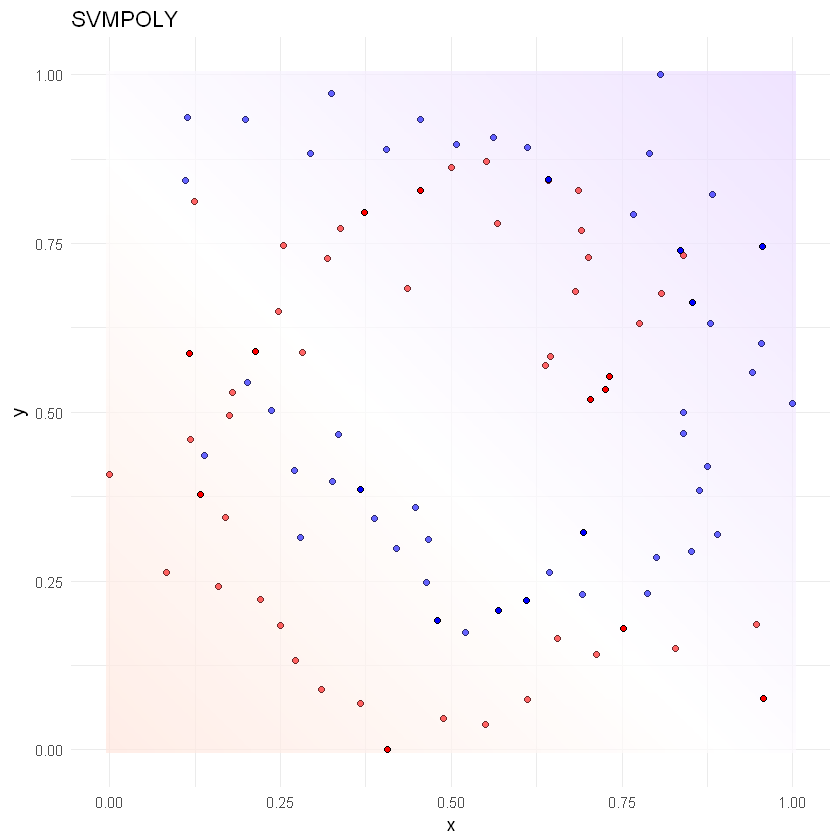

In [4]:
plot_model(df, data_name, model)

Pretty bad, don't you think? This is because we set a 1-degree polynomial kernel. With this approach, the SVM degenerates to a simpler Support Vector *Classifier*, which is much less powerful. 

### Tweak SVM Hyperparameters

Let's profit of the *kernel trick* and try changing some hyperparatemers.

In [5]:
## set the hyperparameters

degree = 3
scale = 0.33
cost = 3

hyperparameters = data.frame('degree' = degree,
                             'scale' = scale,
                             'C' = cost)

In [6]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           trControl = trainControl(method = 'boot',
                                    classProbs =  TRUE)
           )

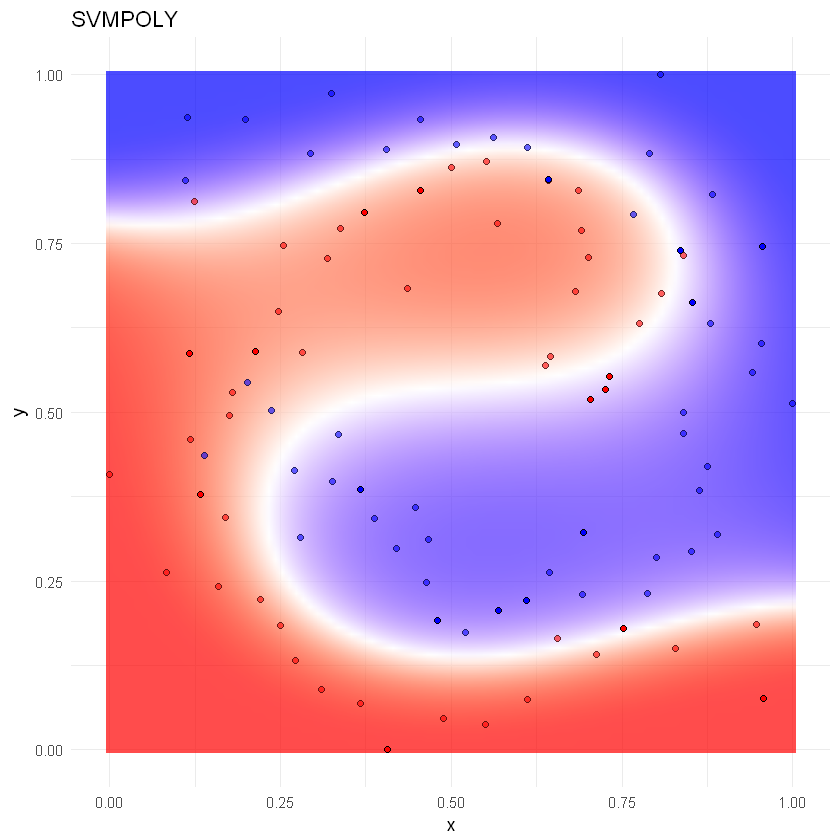

In [7]:
plot_model(df, data_name, model)

Now change kernel type and go for a **radial kernel**:

$$K(x_i, x_{i'}) = \exp\big(-\gamma \sum_{j=1}^{p}(x_{ij}-x_{i'j})^2\big)$$

where:

* $\gamma$ is the *scale* parameter, which set the speed of the exponential decay
* this kernel function is suspiciously similar to the KNN framework...

In [8]:
algorithm = 'svmRadial'

info[[algorithm]]$parameters

parameter,class,label
sigma,numeric,Sigma
C,numeric,Cost


Cost has the same interpretation as of above.

In [9]:
model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           trControl = trainControl(method = 'boot',
                                    classProbs =  TRUE)
           )

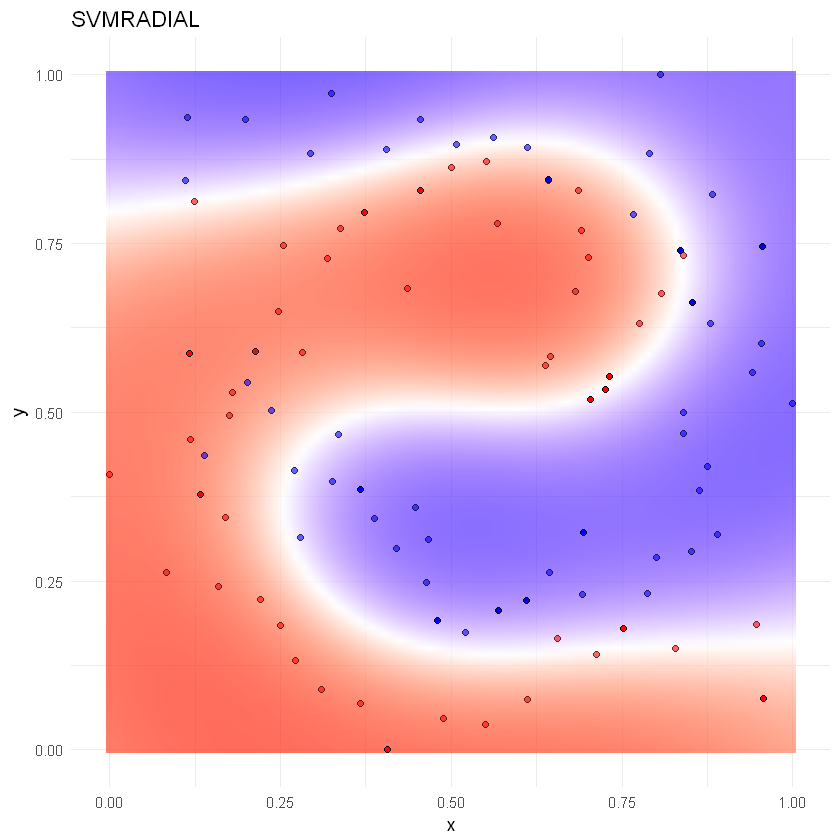

In [10]:
plot_model(df, data_name, model)

## Decision Trees

One of the most renowned DT algorithms is called ID3: Iterative Dichotomizer. All others are pretty similar. 

In a nutshell, ID3 repeatedly partitions the data across the features in an attempt to discriminate the classes. The partitioning is performed based on an Information Gain $IG$ principle, a criterion based on a measure of entropy $H$ in the dataset or in its partitions $S$.
The partitioning recursively happens for every branch until
* the information gain from a further partitioning is too low;
* all the instances $x$ in a partition belongs to the same class $Y$;
* a pre-defined number of iteration is reached.

Notably:

* Entropy: $H(S) = \sum_{x \in Y} -p(y) \log_{2}p(y)$

* Information Gain: $IG(A,S) = H(S) - \sum_{t \in T} p(t)H(t)$

Where:
* $H(S)$ – is the entropy of set $S$
* $T$ – The subsets created from splitting set $S$ by attribute $A$ such that $S = \bigcup_{t \in T} t$
*$p(t)$ – The proportion of the number of elements in $t$ to the number of elements in set $S$
* $H(t)$ – Entropy of subset $t$

In [31]:
## choose the algorithm

algorithm = 'rpart2'

info[[algorithm]]$parameters

parameter,class,label
maxdepth,numeric,Max Tree Depth


In [32]:
## set the hyperparameters

maxdepth = 1

hyperparameters = data.frame('maxdepth' = maxdepth)

In [33]:
model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           trControl = trainControl(method = 'boot')
           )

Loading required package: rpart


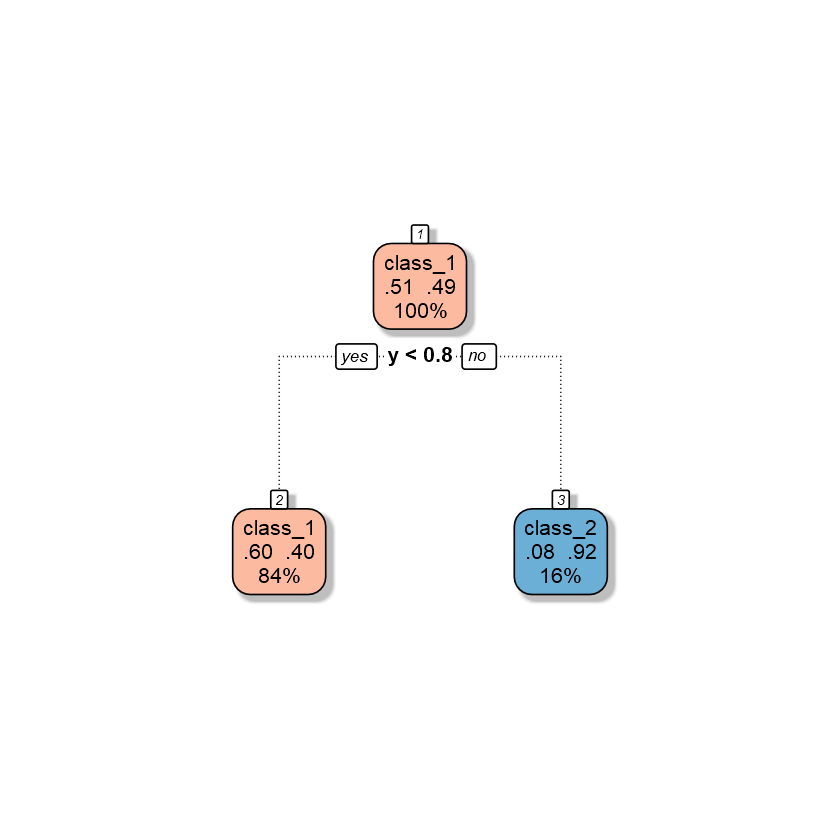

In [34]:
## plot splitting iterations

fancyRpartPlot(model$finalModel, palettes = c('Reds', 'Blues'), sub = "")

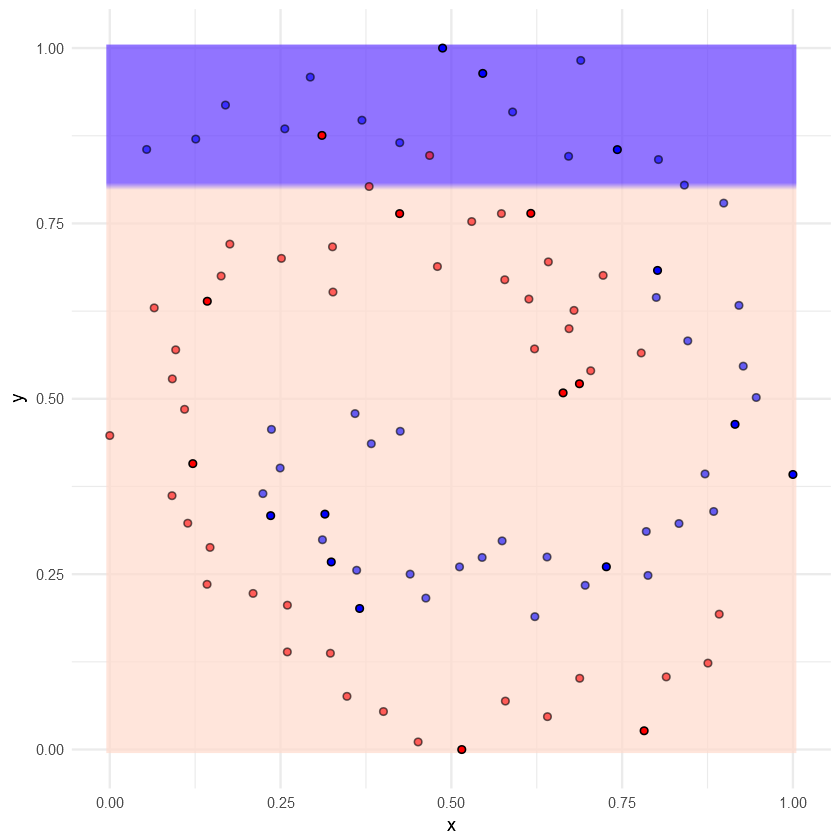

In [35]:
plot_model(df, data_name, model)

### Tweak DT Hyperparameters

In [37]:
## set the hyperparameters

maxdepth = seq_len(10)

hyperparameters = data.frame('maxdepth' = maxdepth)

In [38]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
           x = df[[data_name]]$x_train,
           method = algorithm,
           tuneGrid = hyperparameters,
           trControl = trainControl(method = 'boot')
           )

We cannot really set the exact value of the tree length, which is indeed determined by
* the information gain
* the residual entropy

therefore, the ML algorithm iteratively tries different solutions and selects the best one. What does *the best one* mean? Food for thought, for next session!

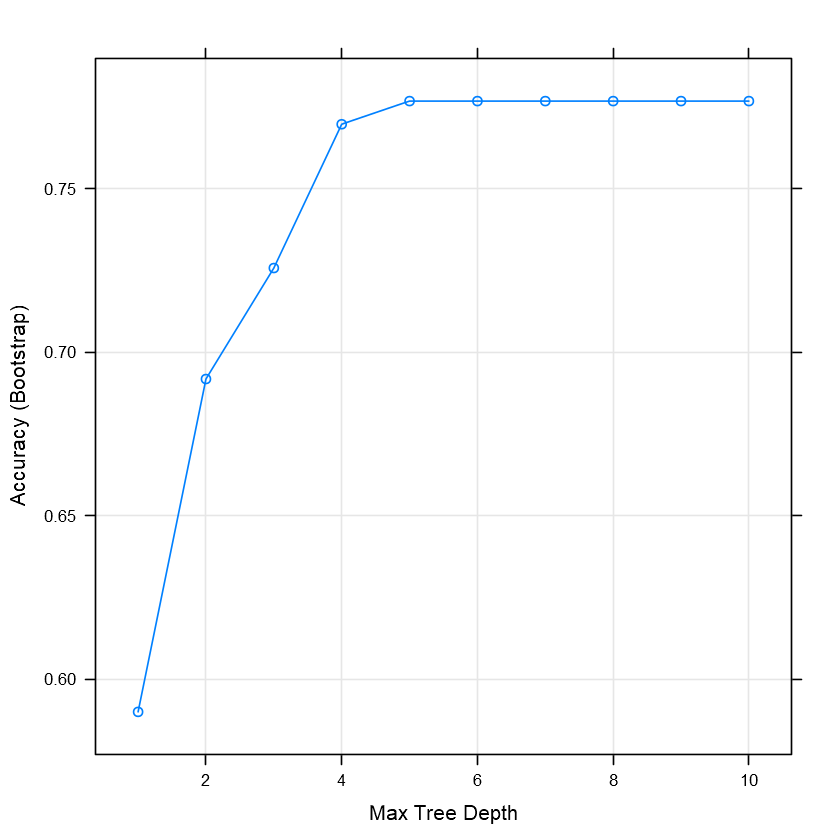

In [39]:
plot(model)

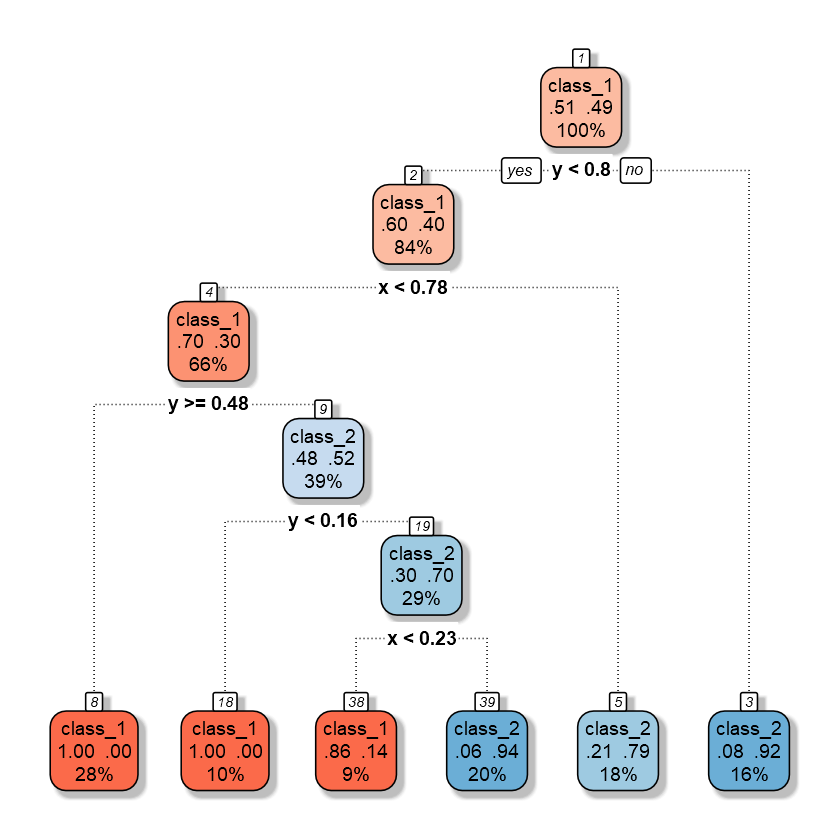

In [40]:
## plot splitting iterations

fancyRpartPlot(model$finalModel, palettes = c('Reds', 'Blues'), sub = "")

This looks neat!

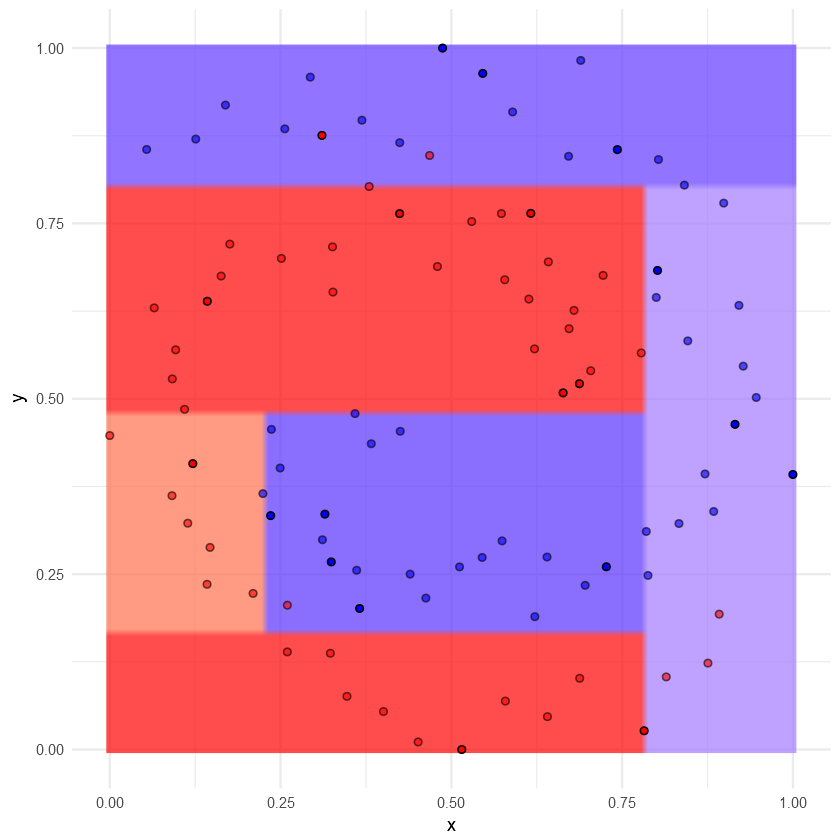

In [41]:
plot_model(df, data_name, model)

## Random Forests

They are a quite natural extension of decision trees. They aim in solving some overfitting problem of classic decision trees.

Basically a RF is the average prediction a bunch of DTs fitted on random subsample of the dataset. In our case it is not too much of a problem, as we just have two features, but in a more complex setting this approach can really make the difference.

In [42]:
## choose the algorithm

algorithm = 'rf'
  
info[[algorithm]]$parameters
  
## set the hyperparameter

mtry = 1
  
hyperparameters = data.frame('mtry' = mtry)

parameter,class,label
mtry,numeric,#Randomly Selected Predictors


In [43]:
## train the model

model = train(y = df[[data_name]]$y_train$class,
                x = df[[data_name]]$x_train,
                method = algorithm,
                tuneGrid = hyperparameters,
                trControl = trainControl(method = 'boot')
  )

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin



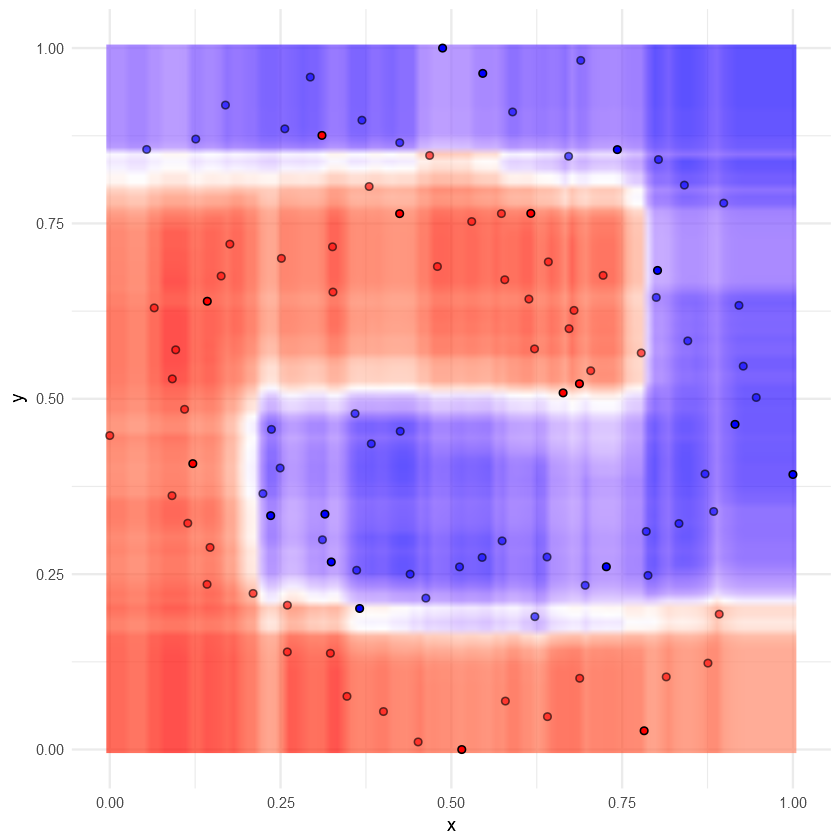

In [44]:
plot_model(df, data_name, model)